## Calculating function vectors for qiskit circuits

To fully evaluate the effectiveness of a circuit, we have to transform it into a function that contains parameters. We can then insert any parameters and evaluate the resulting state space.

$$
\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}
\newcommand{\ketbra}[2]{\left|{#1}\middle\rangle\langle{#2}\right|}
$$

In [6]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit.visualization import plot_state_qsphere
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import QasmSimulator
import qiskit.quantum_info as qi
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

from pennylane.optimize import NesterovMomentumOptimizer, AdamOptimizer

#import numpy as np
from pennylane import numpy as np

import warnings
warnings.simplefilter('ignore')

First we begin with a very simple circuit

In [7]:
circuit = QuantumCircuit(1)
circuit.ry(Parameter('theta'),0)
circuit.draw()

┌───────────┐
q_0: ┤ Ry(theta) ├
     └───────────┘

We now have a 1 qubit circuit that contains an RY-Gate. The RY gate is defined as follows:

$$
RY(\theta) = \begin{pmatrix}
    \cos\frac{\theta}{2} & -\sin\frac{\theta}{2} \\ \sin\frac{\theta}{2} & \cos\frac{\theta}{2}
\end{pmatrix}\\
$$

So let us calculate the final state vector u\sing $\theta$ as variable

$$
\ket{0} = \begin{pmatrix} 1 \\ 0 \end{pmatrix}\\
$$

$$
\ket{\psi} =\ RY(\theta)\ket{0} =\ \begin{pmatrix}\cos\frac{\theta}{2} \\ \sin\frac{\theta}{2}\end{pmatrix}\\
$$

To validate the correctness of the calculation, we will try out 3 different values and compare them to the predicted output in `qiskit`

_For_ $\theta =\ \frac{\pi}{2}$:

$$
\begin{pmatrix}\cos\frac{\pi}{4} \\ \sin\frac{\pi}{4}\end{pmatrix} =\ \frac{1}{\sqrt{4}}\begin{pmatrix} 1 \\ 1\end{pmatrix} =\ \frac{1}{\sqrt{2}}\begin{pmatrix} 1 \\ 0\end{pmatrix} + \frac{1}{\sqrt{2}}\begin{pmatrix} 0 \\ 1\end{pmatrix}
$$

This shows we should have exactly a 50/50 chance of getting 1 or 0 when measuring the circuit with $\theta =\ \frac{\pi}{2}$

In [8]:
def parameterize_and_plot(qc, parameters):
    parameterized_circuit = qc.bind_parameters(parameters)
    parameterized_circuit.measure_all()
    simulator = QasmSimulator()
    compiled_circuit = transpile(parameterized_circuit, simulator)
    job = simulator.run(compiled_circuit, shots=10000)
    result = job.result()
    counts = result.get_counts(parameterized_circuit)
    display(plot_histogram(counts))

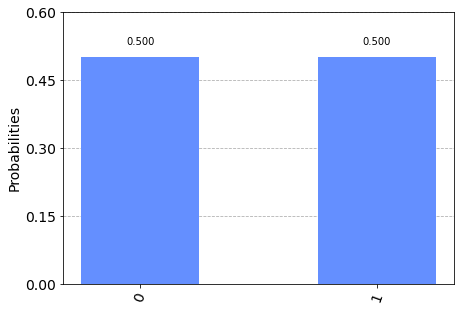

In [9]:
parameterize_and_plot(circuit.copy(), [np.pi/2])

As we can see, it holds up. If we take the state vector of the circuit, we can see why:

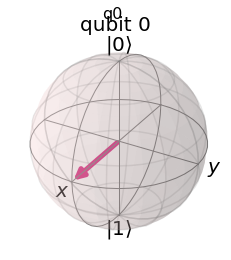

In [10]:
state = Statevector.from_instruction(circuit.copy().bind_parameters([np.pi/2]))
plot_bloch_multivector(state, title="q0", reverse_bits=False)

This means that halving $\pi$ again, so that we get $\frac{pi}{4}$, should return probabilities of ~1/4 and ~3/4:

_For_ $\theta =\ \frac{\pi}{4}$:

$$
\begin{pmatrix}\cos\frac{\pi}{8} \\ \sin\frac{\pi}{8}\end{pmatrix} =\ \begin{pmatrix} 0.9239 \\ 0.3827 \end{pmatrix} =\ \begin{pmatrix} 0.9239 \\ 0 \end{pmatrix} + \begin{pmatrix} 0 \\ 0.3827 \end{pmatrix} =\ 0.9239  \begin{pmatrix} 1 \\ 0 \end{pmatrix} + 0.3827  \begin{pmatrix} 0 \\ 1 \end{pmatrix}
$$

To get the _exact_ probabilities, we have to square the values infront of the two state vectors, which results in the following, final form:

$$
\ket{0} \rightarrow 0.9239^2 =\ 0.8536 \\
\ket{1} \rightarrow 0.382t^2 =\ 0.1464 \\
$$


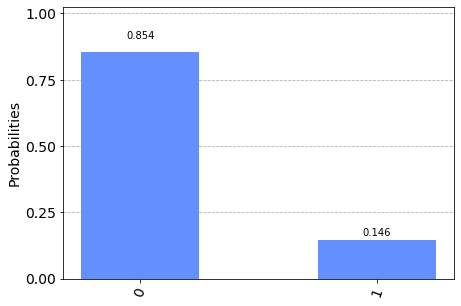

In [11]:
parameterize_and_plot(circuit.copy(), [np.pi/4])

Again, the theory holds. We now want to try to use $\frac{3\pi}{4}$

_For_ $\theta =\ \frac{3\pi}{4}$:

$$
\begin{pmatrix}\cos\frac{3\pi}{8} \\ \sin\frac{3\pi}{8}\end{pmatrix} =\ \begin{pmatrix} 0.3827 \\ 0.9239 \end{pmatrix} =\ \begin{pmatrix} 0.3827 \\ 0 \end{pmatrix} + \begin{pmatrix} 0 \\ 0.9239 \end{pmatrix} =\ 0.3827  \begin{pmatrix} 1 \\ 0 \end{pmatrix} + 0.9239  \begin{pmatrix} 0 \\ 1 \end{pmatrix}
$$

To get the _exact_ probabilities, we have to square the values infront of the two state vectors, which results in the following, final form:

$$
\ket{1} \rightarrow 0.9239^2 =\ 0.8536 \\
\ket{0} \rightarrow 0.382t^2 =\ 0.1464 \\
$$

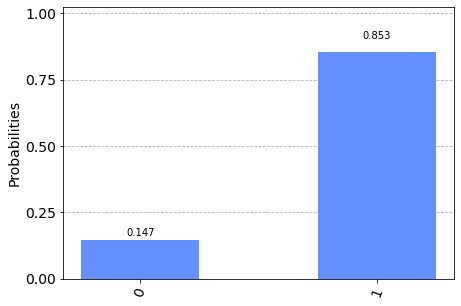

In [12]:
parameterize_and_plot(circuit.copy(), [3*np.pi/4])

As we can see, the probabilities are now inversed. Let's check the bloch sphere:

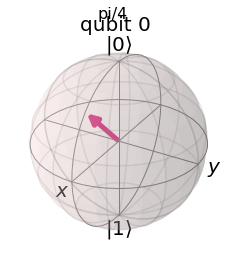

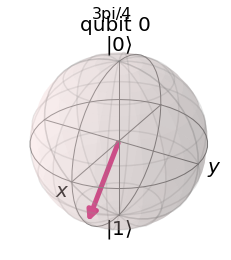

In [13]:
state = Statevector.from_instruction(circuit.copy().bind_parameters([np.pi/4]))
display(plot_bloch_multivector(state, title="pi/4", reverse_bits=False))
state = Statevector.from_instruction(circuit.copy().bind_parameters([3*np.pi/4]))
display(plot_bloch_multivector(state, title="3pi/4", reverse_bits=False))

## Complex circuits

To further allow us to construct mathematical representations of quantum circuits, we need to evaluate more advanced circuits. 

In [14]:
circuit = QuantumCircuit(2)
circuit.ry(Parameter('alpha'), 0)
circuit.cry(Parameter('beta'),0,1)
circuit.draw()

┌───────────┐            
q_0: ┤ Ry(alpha) ├─────■──────
     └───────────┘┌────┴─────┐
q_1: ─────────────┤ Ry(beta) ├
                  └──────────┘

As we can see, this is a circuit that contains 2 qubits, $q_0$ and $q_1$. The initial state of both is $\begin{pmatrix}1 \\ 0\end{pmatrix}$. The first part of the circuit, that is $RY(\alpha)\ket{0}$, remains the same as above and results in the same vector for $q_0$:

$$
q_0 =\ \begin{pmatrix}\cos\frac{\alpha}{2} \\ \sin\frac{\alpha}{2}\end{pmatrix}
$$

As the next gate applies to both our qubits, we have to turn our separate qubit states into one state vector. This can be done by calculating the tensor product of both qubit states:

$$
\begin{pmatrix}\cos\frac{\alpha}{2} \\ \sin\frac{\alpha}{2}\end{pmatrix} \otimes \begin{pmatrix}1 \\ 0\end{pmatrix} =\ 
\begin{pmatrix} \cos\frac{\alpha}{2} \\ 0 \\ \sin\frac{\alpha}{2} \\ 0\end{pmatrix}\\
$$

This means we have an unknown probability for $\ket{00}$ and $\ket{10}$

The _CRY-Gate_ is special in that there are two versions of it. Depending on which "side" the controlling qubit is, we have to take a different one:

$$
CRY(\theta)_{q_0,q_1} =\ 
    \begin{pmatrix}
        1 & 0 & 0 & 0 \\
        0 & \cos{\frac{\theta}{2}} & 0 & -\sin{\frac{\theta}{2}} \\
        0 & 0 & 1 & 0 \\
        0 & \sin{\frac{\theta}{2}} & 0 & \cos{\frac{\theta}{2}}
        \end{pmatrix}
$$

$$
CRY(\theta)_{q_1,q_0} =\ 
    \begin{pmatrix}
        1 & 0 & 0 & 0 \\
        0 & 1 & 0 & 0 \\
        0 & 0 & \cos\frac{\theta}{2} & -\sin\frac{\theta}{2} \\
        0 & 0 & \sin\frac{\theta}{2} & \cos\frac{\theta}{2}
    \end{pmatrix} \\
$$

Where $q_i$ denotes the control qubit and $q_j$ the target qubit in $CRY(\theta)_{q_i,q_j}$

Remember, that because in `qiskit` the endians are switched, we use $CRY(\beta)_{q_0,q_1}$ here.
Lets now multiply our state vector with our $CRY(\beta)_{q_0,q_1}$ matrix:

$$
\begin{pmatrix}
        1 & 0 & 0 & 0 \\
        0 & 1 & 0 & 0 \\
        0 & 0 & \cos\frac{\theta}{2} & -\sin\frac{\theta}{2} \\
        0 & 0 & \sin\frac{\theta}{2} & \cos\frac{\theta}{2}
\end{pmatrix} \begin{pmatrix} \cos\frac{\alpha}{2} \\ 0 \\ \sin\frac{\alpha}{2} \\ 0\end{pmatrix} =\ \begin{pmatrix} \cos\frac{\alpha}{2} \\ 0 \\ \cos\frac{\beta}{2}\sin\frac{\alpha}{2} \\ \sin\frac{\beta}{2}\sin\frac{\alpha}{2}\end{pmatrix}\\
$$

As we can see the state vector does not change. This means, that if we plug in the same values as above, we should get the same results, no matter what $\beta$ is.

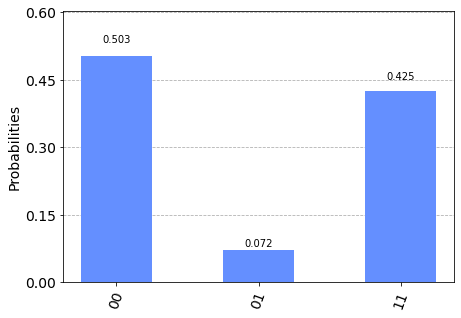

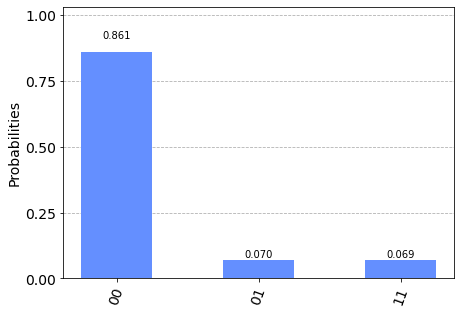

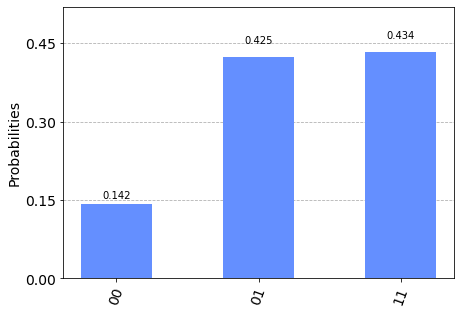

In [15]:
parameterize_and_plot(circuit.copy(),[np.pi/2, 3*np.pi/4])

parameterize_and_plot(circuit.copy(),[np.pi/4, np.pi/2])

parameterize_and_plot(circuit.copy(),[3*np.pi/4, np.pi/2])

In [16]:
circuit = QuantumCircuit(2)
circuit.ry(Parameter('alpha'),0)
circuit.cry(Parameter('beta'),1,0)
circuit.draw()

┌───────────┐┌──────────┐
q_0: ┤ Ry(alpha) ├┤ Ry(beta) ├
     └───────────┘└────┬─────┘
q_1: ──────────────────■──────

What if we turn the _CRY-Gate_ upside down? The state vector right before it is applied remains the same, but the outcome of the multiplication by $RY(\theta)_{q_1,q_0}$ should differ:

$$
\begin{pmatrix}
    1 & 0 & 0 & 0 \\
    0 & \cos{\frac{\beta}{2}} & 0 & -\sin{\frac{\beta}{2}} \\
    0 & 0 & 1 & 0 \\
    0 & \sin{\frac{\beta}{2}} & 0 & \cos{\frac{\beta}{2}}
\end{pmatrix} \begin{pmatrix} \cos\frac{\alpha}{2} \\ 0 \\ \sin\frac{\alpha}{2} \\ 0\end{pmatrix} =\ \begin{pmatrix} \cos\frac{\alpha}{2} \\ 0 \\ \sin\frac{\alpha}{2} \\ 0\end{pmatrix} \\
$$

And as we can see, it does indeed differ. We now not only have chances of measuring $\ket{00}$ and $\ket{10}$, but surpr\singly also $\ket{11}$, even tho we never _directly_ interfered with $q_1$. Lets simulate this and see the outcome:

In [17]:
def print_unitary_matrix(circuit, parameters):
    qc = circuit.bind_parameters(parameters)
    backend = Aer.get_backend('unitary_simulator')
    job = execute(qc, backend)
    result = job.result()
    print(result.get_unitary(qc, decimals=3))

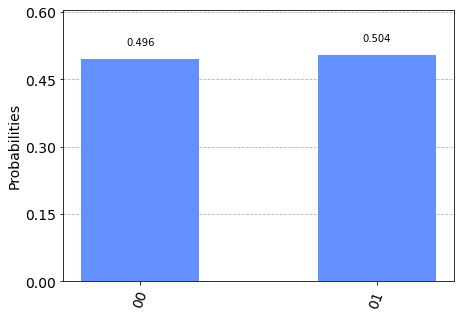

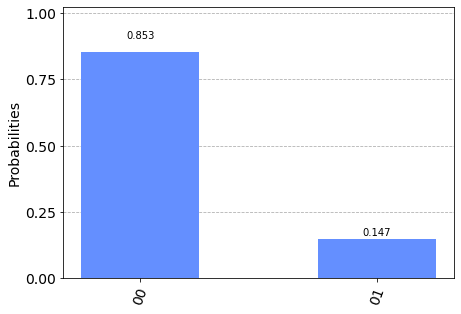

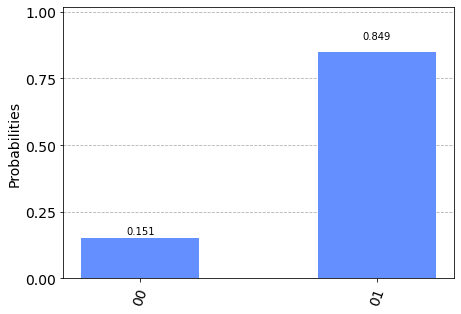

In [18]:
parameterize_and_plot(circuit.copy(),[np.pi/2, 3*np.pi/4])

parameterize_and_plot(circuit.copy(),[np.pi/4, np.pi/2])

parameterize_and_plot(circuit.copy(),[3*np.pi/4, np.pi/2])

As we can see, this circuit does not differ from the\single qubit one. The cause for this is that $q_1$ is always $\ket{0}$.

## Classification Circuits

We will now create the final state matrix for the circuit created in the training notebook. This circuit is the one that was rated best from our testing.

In [21]:
feature_map = QuantumCircuit(4)
ansatz = QuantumCircuit(4)
for i in range(4):
    feature_map.ry(Parameter('a_' + str(i)),i)
    ansatz.ry(Parameter('w_' + str(i)),i)
    ansatz.cry(Parameter('w_' + str(10+i)), i, (i+1)%4)


qc = QuantumCircuit(4)
qc.append(feature_map, range(4))
qc.append(ansatz, range(4))
qc.decompose().draw()

┌─────────┐┌─────────┐                                              »
q_0: ┤ Ry(a_0) ├┤ Ry(w_0) ├─────■────────────────────────────────────────»
     ├─────────┤└─────────┘┌────┴─────┐┌─────────┐                       »
q_1: ┤ Ry(a_1) ├───────────┤ Ry(w_10) ├┤ Ry(w_1) ├─────■─────────────────»
     ├─────────┤           └──────────┘└─────────┘┌────┴─────┐┌─────────┐»
q_2: ┤ Ry(a_2) ├──────────────────────────────────┤ Ry(w_11) ├┤ Ry(w_2) ├»
     ├─────────┤                                  └──────────┘└─────────┘»
q_3: ┤ Ry(a_3) ├─────────────────────────────────────────────────────────»
     └─────────┘                                                         »
«                            ┌──────────┐
«q_0: ───────────────────────┤ Ry(w_13) ├
«                            └────┬─────┘
«q_1: ────────────────────────────┼──────
«                                 │      
«q_2: ─────■──────────────────────┼──────
«     ┌────┴─────┐┌─────────┐     │      
«q_3: ┤ Ry(w_12) ├┤ Ry(w_3) ├─────■──────
«     └──────────┘└─────────┘

```
     ┌─────────┐┌─────────┐                                                                     ┌──────────┐
q_0: ┤ Ry(a_0) ├┤ Ry(w_0) ├─────■───────────────────────────────────────────────────────────────┤ Ry(w_13) ├
     ├─────────┤└─────────┘┌────┴─────┐┌─────────┐                                              └────┬─────┘
q_1: ┤ Ry(a_1) ├───────────┤ Ry(w_10) ├┤ Ry(w_1) ├─────■─────────────────────────────────────────────┼──────
     ├─────────┤           └──────────┘└─────────┘┌────┴─────┐┌─────────┐                            │     
q_2: ┤ Ry(a_2) ├──────────────────────────────────┤ Ry(w_11) ├┤ Ry(w_2) ├─────■──────────────────────┼──────
     ├─────────┤                                  └──────────┘└─────────┘┌────┴─────┐┌─────────┐     │      
q_3: ┤ Ry(a_3) ├─────────────────────────────────────────────────────────┤ Ry(w_12) ├┤ Ry(w_3) ├─────■──────
     └─────────┘                                                         └──────────┘└─────────┘ 
               psi1      psi2          psi3     psi4        psi5        psi6       psi7       psi8          psi9
```






 

Here, our initial states of all qubits $q_i$ is $\ket{0}$, so $\begin{pmatrix}1 \\ 0\end{pmatrix}$. First, lets turn our initial vectors into ones passed trough $RY(\alpha_i)$.

$$
\ket{\psi_1} =\ \begin{pmatrix}\cos\frac{\alpha_i}{2} \\ \sin\frac{\alpha_i}{2}\end{pmatrix}
$$

Now we have the weights for the $RY(\theta)$ and $CRY(\theta)$ gates. For better visual reference we will use $\omega_i$ to define the weights.

$$
\ket{\psi_2} =\ \begin{pmatrix}
    \cos\frac{\omega_0}{2} & -\sin\frac{\omega_0}{2} \\ \sin\frac{\omega_0}{2} & \cos\frac{\omega_0}{2}
\end{pmatrix} 
\begin{pmatrix}
    \cos\frac{\alpha_0}{2} \\ \sin\frac{\alpha_0}{2}
\end{pmatrix} =\ \begin{pmatrix}
    \cos\frac{\omega_0}{2}\cos\frac{\alpha_0}{2} - \sin\frac{\omega_0}{2}\sin\frac{\alpha_0}{2}\\
    \sin\frac{\omega_0}{2}\cos\frac{\alpha_0}{2} + \cos\frac{\omega_0}{2}\sin\frac{\alpha_0}{2}
\end{pmatrix}\\
$$

Before we can apply the first $CRY(\omega_{10})$ gate, we now have to get the tensor product of the first and the second qubit.

$$
\begin{pmatrix}
    \cos\frac{\omega_0}{2}\cos\frac{\alpha_0}{2} - \sin\frac{\omega_0}{2}\sin\frac{\alpha_0}{2}\\
    \sin\frac{\omega_0}{2}\cos\frac{\alpha_0}{2} + \cos\frac{\omega_0}{2}\sin\frac{\alpha_0}{2}
\end{pmatrix} 
\otimes 
\begin{pmatrix}\cos\frac{\alpha_1}{2} \\ \sin\frac{\alpha_1}{2}\end{pmatrix} =\ 
\begin{pmatrix}
    \cos\frac{\alpha_1}{2}(\cos\frac{\omega_0}{2}\cos\frac{\alpha_0}{2} - \sin\frac{\omega_0}{2}\sin\frac{\alpha_0}{2}) \\
    \sin\frac{\alpha_1}{2}(\cos\frac{\omega_0}{2}\cos\frac{\alpha_0}{2} - \sin\frac{\omega_0}{2}\sin\frac{\alpha_0}{2}) \\
    \cos\frac{\alpha_1}{2}(\sin\frac{\omega_0}{2}\cos\frac{\alpha_0}{2} + \cos\frac{\omega_0}{2}\sin\frac{\alpha_0}{2}) \\
    \sin\frac{\alpha_1}{2}(\sin\frac{\omega_0}{2}\cos\frac{\alpha_0}{2} + \cos\frac{\omega_0}{2}\sin\frac{\alpha_0}{2}) \\
\end{pmatrix} \\
$$

Now we can multiply it with the $CRY(\omega_{10})$ matrix

$$
\ket{\psi_3} =\ \begin{pmatrix}
        1 & 0 & 0 & 0 \\
        0 & 1 & 0 & 0 \\
        0 & 0 & \cos\frac{\omega_{10}}{2} & -\sin\frac{\omega_{10}}{2} \\
        0 & 0 & \sin\frac{\omega_{10}}{2} & \cos\frac{\omega_{10}}{2}
\end{pmatrix} \begin{pmatrix}
    \cos\frac{\alpha_1}{2}(\cos\frac{\omega_0}{2}\cos\frac{\alpha_0}{2} - \sin\frac{\omega_0}{2}\sin\frac{\alpha_0}{2}) \\
    \sin\frac{\alpha_1}{2}(\cos\frac{\omega_0}{2}\cos\frac{\alpha_0}{2} - \sin\frac{\omega_0}{2}\sin\frac{\alpha_0}{2}) \\
    \cos\frac{\alpha_1}{2}(\sin\frac{\omega_0}{2}\cos\frac{\alpha_0}{2} + \cos\frac{\omega_0}{2}\sin\frac{\alpha_0}{2}) \\
    \sin\frac{\alpha_1}{2}(\sin\frac{\omega_0}{2}\cos\frac{\alpha_0}{2} + \cos\frac{\omega_0}{2}\sin\frac{\alpha_0}{2}) \\
\end{pmatrix} =\ \begin{pmatrix}
    \cos\frac{\alpha_1}{2}(\cos\frac{\omega_0}{2}\cos\frac{\alpha_0}{2} - \sin\frac{\omega_0}{2}\sin\frac{\alpha_0}{2}) \\
    \sin\frac{\alpha_1}{2}(\cos\frac{\omega_0}{2}\cos\frac{\alpha_0}{2} - \sin\frac{\omega_0}{2}\sin\frac{\alpha_0}{2}) \\
    \cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_1}{2}(\sin\frac{\omega_0}{2}\cos\frac{\alpha_0}{2} + \cos\frac{\omega_0}{2}\sin\frac{\alpha_0}{2})) 
    - \sin\frac{\omega_{10}}{2}(\sin\frac{\alpha_1}{2}(\sin\frac{\omega_0}{2}\cos\frac{\alpha_0}{2} + \cos\frac{\omega_0}{2}\sin\frac{\alpha_0}{2})) \\
    \sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_1}{2}(\sin\frac{\omega_0}{2}\cos\frac{\alpha_0}{2} + \cos\frac{\omega_0}{2}\sin\frac{\alpha_0}{2})) 
    + \cos\frac{\omega_{10}}{2}(\sin\frac{\alpha_1}{2}(\sin\frac{\omega_0}{2}\cos\frac{\alpha_0}{2} + \cos\frac{\omega_0}{2}\sin\frac{\alpha_0}{2})) \\
\end{pmatrix}
$$

Now we can go on and apply the next $RY(\omega_1)$ gate. This case is now special - as we are dealing with a 4 dimensional vector space, we have to transform the $RY(\omega)$ gate. To do so, we go as follows:



$$
I^{2\times2} = \begin{pmatrix}1 & 0 \\ 0 & 1\end{pmatrix} \\
\\
I^{2\times2} \otimes \begin{pmatrix}
    \cos\frac{\theta}{2} & -\sin\frac{\theta}{2} \\ \sin\frac{\theta}{2} & \cos\frac{\theta}{2}
\end{pmatrix} = \begin{pmatrix}
    \cos\frac{\theta}{2} & -\sin\frac{\theta}{2} & 0 & 0 \\
    \sin\frac{\theta}{2} & \cos\frac{\theta}{2} & 0 & 0 \\
    0 & 0 & \cos\frac{\theta}{2} & -\sin\frac{\theta}{2} \\
    0 & 0 & \sin\frac{\theta}{2} & \cos\frac{\theta}{2} \\
\end{pmatrix}
$$

And with this we can now calculate the next step in our circuit:

$$
\begin{pmatrix}
    \cos\frac{\omega_1}{2} & -\sin\frac{\omega_1}{2} & 0 & 0 \\
    \sin\frac{\omega_1}{2} & \cos\frac{\omega_1}{2} & 0 & 0 \\
    0 & 0 & \cos\frac{\omega_1}{2} & -\sin\frac{\omega_1}{2} \\
    0 & 0 & \sin\frac{\omega_1}{2} & \cos\frac{\omega_1}{2} \\
\end{pmatrix} \begin{pmatrix}
    \cos\frac{\alpha_1}{2}(\cos\frac{\omega_0}{2}\cos\frac{\alpha_0}{2} - \sin\frac{\omega_0}{2}\sin\frac{\alpha_0}{2}) \\
    \sin\frac{\alpha_1}{2}(\cos\frac{\omega_0}{2}\cos\frac{\alpha_0}{2} - \sin\frac{\omega_0}{2}\sin\frac{\alpha_0}{2}) \\
    \cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_1}{2}(\sin\frac{\omega_0}{2}\cos\frac{\alpha_0}{2} + \cos\frac{\omega_0}{2}\sin\frac{\alpha_0}{2})) 
    - \sin\frac{\omega_{10}}{2}(\sin\frac{\alpha_1}{2}(\sin\frac{\omega_0}{2}\cos\frac{\alpha_0}{2} + \cos\frac{\omega_0}{2}\sin\frac{\alpha_0}{2})) \\
    \sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_1}{2}(\sin\frac{\omega_0}{2}\cos\frac{\alpha_0}{2} + \cos\frac{\omega_0}{2}\sin\frac{\alpha_0}{2})) 
    + \cos\frac{\omega_{10}}{2}(\sin\frac{\alpha_1}{2}(\sin\frac{\omega_0}{2}\cos\frac{\alpha_0}{2} + \cos\frac{\omega_0}{2}\sin\frac{\alpha_0}{2})) \\
\end{pmatrix} \\
$$
$$
\ket{\psi_4} =\ \begin{pmatrix}
     \cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})\\
     \cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})\\
     \cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))\\
     \cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))\\
\end{pmatrix}
$$


We now do another step of increasing the state vector by multiplying with $\ket{q_2}$

$$
\ket{\psi_4'} =\ \ket{\psi_4} \otimes \begin{pmatrix}\cos\frac{\alpha_2}{2} \\ \sin\frac{\alpha_2}{2}\end{pmatrix} = \begin{pmatrix}
     \cos\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))\\
     \sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))\\
     \cos\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))\\
     \sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))\\
     \cos\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))\\
     \sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))\\
     \cos\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))\\
     \sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))\\
     \end{pmatrix}
$$

Now we have to increase the $CRY(\theta)$ gate to match our 8 dimensional state vector:

$$
I^{2\times2} \otimes CRY(\omega_11) =\ \begin{pmatrix}
     1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
     0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\
     0 & 0 & \cos\frac{\omega_{11}}{2} & -\sin\frac{\omega_{11}}{2} & 0 & 0 & 0 & 0\\
     0 & 0 & \sin\frac{\omega_{11}}{2} & \cos\frac{\omega_{11}}{2} & 0 & 0 & 0 & 0\\
     0 & 0 & 0 & 0 & 1 & 0 & 0 & 0\\
     0 & 0 & 0 & 0 & 0 & 1 & 0 & 0\\
     0 & 0 & 0 & 0 & 0 & 0 & \cos\frac{\omega_{11}}{2} & -\sin\frac{\omega_{11}}{2}\\
     0 & 0 & 0 & 0 & 0 & 0 & \sin\frac{\omega_{11}}{2} & \cos\frac{\omega_{11}}{2}\\
     \end{pmatrix}
$$

And now we calculate $\ket{\psi_5}$

$$
\ket{\psi_5} =\ \begin{pmatrix}
     1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
     0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\
     0 & 0 & \cos\frac{\omega_{11}}{2} & -\sin\frac{\omega_{11}}{2} & 0 & 0 & 0 & 0\\
     0 & 0 & \sin\frac{\omega_{11}}{2} & \cos\frac{\omega_{11}}{2} & 0 & 0 & 0 & 0\\
     0 & 0 & 0 & 0 & 1 & 0 & 0 & 0\\
     0 & 0 & 0 & 0 & 0 & 1 & 0 & 0\\
     0 & 0 & 0 & 0 & 0 & 0 & \cos\frac{\omega_{11}}{2} & -\sin\frac{\omega_{11}}{2}\\
     0 & 0 & 0 & 0 & 0 & 0 & \sin\frac{\omega_{11}}{2} & \cos\frac{\omega_{11}}{2}\\
     \end{pmatrix} \ket{\psi_4'} \\ 
$$
$$
      =\ \begin{pmatrix}
     \cos\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))\\
     \sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))\\
     \cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))\\
     \cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))\\
     \cos\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))\\
     \sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))\\
     \cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))\\
     \cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))\\
     \end{pmatrix}
$$

Increasin the $RY(\theta)$ size:

$$
I^{4\times4} \otimes RY(\omega_2) =\ \begin{pmatrix}
     \cos\frac{\omega_{2}}{2} & -\sin\frac{\omega_{2}}{2} & 0 & 0 & 0 & 0 & 0 & 0\\
     \sin\frac{\omega_{2}}{2} & \cos\frac{\omega_{2}}{2} & 0 & 0 & 0 & 0 & 0 & 0\\
     0 & 0 & \cos\frac{\omega_{2}}{2} & -\sin\frac{\omega_{2}}{2} & 0 & 0 & 0 & 0\\
     0 & 0 & \sin\frac{\omega_{2}}{2} & \cos\frac{\omega_{2}}{2} & 0 & 0 & 0 & 0\\
     0 & 0 & 0 & 0 & \cos\frac{\omega_{2}}{2} & -\sin\frac{\omega_{2}}{2} & 0 & 0\\
     0 & 0 & 0 & 0 & \sin\frac{\omega_{2}}{2} & \cos\frac{\omega_{2}}{2} & 0 & 0\\
     0 & 0 & 0 & 0 & 0 & 0 & \cos\frac{\omega_{2}}{2} & -\sin\frac{\omega_{2}}{2}\\
     0 & 0 & 0 & 0 & 0 & 0 & \sin\frac{\omega_{2}}{2} & \cos\frac{\omega_{2}}{2}\\
     \end{pmatrix}
$$

And now calculate $\ket{\psi_6}$:

$$
\ket{\psi_6} =\ \begin{pmatrix}
     \cos\frac{\omega_{2}}{2} & -\sin\frac{\omega_{2}}{2} & 0 & 0 & 0 & 0 & 0 & 0\\
     \sin\frac{\omega_{2}}{2} & \cos\frac{\omega_{2}}{2} & 0 & 0 & 0 & 0 & 0 & 0\\
     0 & 0 & \cos\frac{\omega_{2}}{2} & -\sin\frac{\omega_{2}}{2} & 0 & 0 & 0 & 0\\
     0 & 0 & \sin\frac{\omega_{2}}{2} & \cos\frac{\omega_{2}}{2} & 0 & 0 & 0 & 0\\
     0 & 0 & 0 & 0 & \cos\frac{\omega_{2}}{2} & -\sin\frac{\omega_{2}}{2} & 0 & 0\\
     0 & 0 & 0 & 0 & \sin\frac{\omega_{2}}{2} & \cos\frac{\omega_{2}}{2} & 0 & 0\\
     0 & 0 & 0 & 0 & 0 & 0 & \cos\frac{\omega_{2}}{2} & -\sin\frac{\omega_{2}}{2}\\
     0 & 0 & 0 & 0 & 0 & 0 & \sin\frac{\omega_{2}}{2} & \cos\frac{\omega_{2}}{2}\\
     \end{pmatrix} \ket{\psi_5} =\ \\
$$
$$
\begin{pmatrix}
     \cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))\\
     \cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))\\
     \cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) - \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))\\
     \cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))\\
     \cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))\\
     \cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))\\
     \cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) - \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))\\
     \cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))\\
     \end{pmatrix}
$$


Again, we increase the dimensionality of $\ket{\psi_6}$:
$$
\ket{\psi_6'} =\ \ket{\psi_6} \otimes \begin{pmatrix}\cos\frac{\alpha_3}{2} \\ \sin\frac{\alpha_3}{2}\end{pmatrix} =\ 
$$
$$
\begin{pmatrix}
     \cos\frac{\alpha_{3}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))\\
     \sin\frac{\alpha_{3}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))\\
     \cos\frac{\alpha_{3}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))\\
     \sin\frac{\alpha_{3}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))\\
     \cos\frac{\alpha_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) - \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))))\\
     \sin\frac{\alpha_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) - \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))))\\
     \cos\frac{\alpha_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))))\\
     \sin\frac{\alpha_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))))\\
     \cos\frac{\alpha_{3}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))\\
     \sin\frac{\alpha_{3}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))\\
     \cos\frac{\alpha_{3}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))\\
     \sin\frac{\alpha_{3}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))\\
     \cos\frac{\alpha_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) - \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))))\\
     \sin\frac{\alpha_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) - \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))))\\
     \cos\frac{\alpha_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))))\\
     \sin\frac{\alpha_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))))\\
     \end{pmatrix}
$$

For the last time now, we have to increase the dimension of $CRY(\theta)$

$$
CRY(\omega_{12})^{16\times16} =\ I^{2\times2} \otimes CRY(\omega_{12}) =\ \\
$$
$$
\begin{pmatrix}
     1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
     0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
     0 & 0 & \cos\frac{\omega_{12}}{2} & -\sin\frac{\omega_{12}}{2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
     0 & 0 & \sin\frac{\omega_{12}}{2} & \cos\frac{\omega_{12}}{2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
     0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
     0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
     0 & 0 & 0 & 0 & 0 & 0 & \cos\frac{\omega_{12}}{2} & -\sin\frac{\omega_{12}}{2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
     0 & 0 & 0 & 0 & 0 & 0 & \sin\frac{\omega_{12}}{2} & \cos\frac{\omega_{12}}{2} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
     0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
     0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\
     0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \cos\frac{\omega_{12}}{2} & -\sin\frac{\omega_{12}}{2} & 0 & 0 & 0 & 0\\
     0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \sin\frac{\omega_{12}}{2} & \cos\frac{\omega_{12}}{2} & 0 & 0 & 0 & 0\\
     0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0\\
     0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0\\
     0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \cos\frac{\omega_{12}}{2} & -\sin\frac{\omega_{12}}{2}\\
     0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \sin\frac{\omega_{12}}{2} & \cos\frac{\omega_{12}}{2}\\
     \end{pmatrix}
$$


And now for $\ket{\psi_7}$:
$$
\ket{\psi_7} =\ CRY(\omega_{12})^{12\times12}\ket{\psi_6'} =\ \\
$$
$$
\begin{pmatrix}
     \cos\frac{\alpha_{3}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))\\
     \sin\frac{\alpha_{3}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))\\
     \cos\frac{\alpha_{3}}{2}\cos\frac{\omega_{12}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) - \sin\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))\\
     \cos\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) + \cos\frac{\omega_{12}}{2}\sin\frac{\alpha_{3}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))\\
     \cos\frac{\alpha_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) - \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))))\\
     \sin\frac{\alpha_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) - \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))))\\
     \cos\frac{\alpha_{3}}{2}\cos\frac{\omega_{12}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))) - \sin\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))))\\
     \cos\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))) + \cos\frac{\omega_{12}}{2}\sin\frac{\alpha_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))))\\
     \cos\frac{\alpha_{3}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))\\
     \sin\frac{\alpha_{3}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))\\
     \cos\frac{\alpha_{3}}{2}\cos\frac{\omega_{12}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) - \sin\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))\\
     \cos\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) + \cos\frac{\omega_{12}}{2}\sin\frac{\alpha_{3}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))\\
     \cos\frac{\alpha_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) - \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))))\\
     \sin\frac{\alpha_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) - \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))))\\
     \cos\frac{\alpha_{3}}{2}\cos\frac{\omega_{12}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))) - \sin\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))))\\
     \cos\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))) + \cos\frac{\omega_{12}}{2}\sin\frac{\alpha_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))))\\
     \end{pmatrix}
$$

$RY(\omega_3)$:

$$
RY(\omega_3)^{16\times16} =\ I^{8\times8} RY(\omega_3)
$$

And now $\ket{\psi_8}$:

$$
\ket{\psi_8} =\ RY(\omega_3)^{16\times16} \ket{\psi_7} =\ \\
$$
$$
\begin{pmatrix}
     \cos\frac{\alpha_{3}}{2}\cos\frac{\omega_{3}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) - \sin\frac{\alpha_{3}}{2}\sin\frac{\omega_{3}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))\\
     \cos\frac{\alpha_{3}}{2}\sin\frac{\omega_{3}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) + \cos\frac{\omega_{3}}{2}\sin\frac{\alpha_{3}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))\\
     \cos\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\cos\frac{\omega_{12}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) - \sin\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))) - \sin\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) + \cos\frac{\omega_{12}}{2}\sin\frac{\alpha_{3}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))))\\
     \cos\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) + \cos\frac{\omega_{12}}{2}\sin\frac{\alpha_{3}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))) + \sin\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\cos\frac{\omega_{12}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) - \sin\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))))\\
     \cos\frac{\alpha_{3}}{2}\cos\frac{\omega_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) - \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))) - \sin\frac{\alpha_{3}}{2}\sin\frac{\omega_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) - \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))))\\
     \cos\frac{\alpha_{3}}{2}\sin\frac{\omega_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) - \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))) + \cos\frac{\omega_{3}}{2}\sin\frac{\alpha_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) - \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))))\\
     \cos\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\cos\frac{\omega_{12}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))) - \sin\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))))) - \sin\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))) + \cos\frac{\omega_{12}}{2}\sin\frac{\alpha_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))))\\
     \cos\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))) + \cos\frac{\omega_{12}}{2}\sin\frac{\alpha_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))))) + \sin\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\cos\frac{\omega_{12}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))) - \sin\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))))\\
     \cos\frac{\alpha_{3}}{2}\cos\frac{\omega_{3}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) - \sin\frac{\alpha_{3}}{2}\sin\frac{\omega_{3}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))\\
     \cos\frac{\alpha_{3}}{2}\sin\frac{\omega_{3}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) + \cos\frac{\omega_{3}}{2}\sin\frac{\alpha_{3}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))\\
     \cos\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\cos\frac{\omega_{12}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) - \sin\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))) - \sin\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) + \cos\frac{\omega_{12}}{2}\sin\frac{\alpha_{3}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))))\\
     \cos\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) + \cos\frac{\omega_{12}}{2}\sin\frac{\alpha_{3}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))) + \sin\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\cos\frac{\omega_{12}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) - \sin\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))))\\
     \cos\frac{\alpha_{3}}{2}\cos\frac{\omega_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) - \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))) - \sin\frac{\alpha_{3}}{2}\sin\frac{\omega_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) - \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))))\\
     \cos\frac{\alpha_{3}}{2}\sin\frac{\omega_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) - \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))) + \cos\frac{\omega_{3}}{2}\sin\frac{\alpha_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) - \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))))\\
     \cos\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\cos\frac{\omega_{12}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))) - \sin\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))))) - \sin\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))) + \cos\frac{\omega_{12}}{2}\sin\frac{\alpha_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))))\\
     \cos\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))) + \cos\frac{\omega_{12}}{2}\sin\frac{\alpha_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))))) + \sin\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\cos\frac{\omega_{12}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))) - \sin\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))))\\
     \end{pmatrix}
$$

For the last calculation, we have to take the rotated $CRY{\omega}$ matrix.

$$
\ket{\psi_9} = CRY(\omega_{13})\ket{\psi_8} =\ \\
$$
$$\begin{pmatrix}
     \cos\frac{\alpha_{3}}{2}\cos\frac{\omega_{3}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) - \sin\frac{\alpha_{3}}{2}\sin\frac{\omega_{3}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))\\
     \cos\frac{\omega_{13}}{2}(\cos\frac{\alpha_{3}}{2}\sin\frac{\omega_{3}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) + \cos\frac{\omega_{3}}{2}\sin\frac{\alpha_{3}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))) - \sin\frac{\omega_{13}}{2}(\cos\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) + \cos\frac{\omega_{12}}{2}\sin\frac{\alpha_{3}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))) + \sin\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\cos\frac{\omega_{12}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) - \sin\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))))\\
     \cos\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\cos\frac{\omega_{12}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) - \sin\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))) - \sin\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) + \cos\frac{\omega_{12}}{2}\sin\frac{\alpha_{3}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))))\\
     \sin\frac{\omega_{12}}{2}(\cos\frac{\alpha_{3}}{2}\sin\frac{\omega_{3}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) + \cos\frac{\omega_{3}}{2}\sin\frac{\alpha_{3}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))) + \cos\frac{\omega_{12}}{2}(\cos\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) + \cos\frac{\omega_{12}}{2}\sin\frac{\alpha_{3}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))) + \sin\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\cos\frac{\omega_{12}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) - \sin\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))))\\
     \cos\frac{\alpha_{3}}{2}\cos\frac{\omega_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) - \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))) - \sin\frac{\alpha_{3}}{2}\sin\frac{\omega_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) - \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))))\\
     \cos\frac{\omega_{13}}{2}(\cos\frac{\alpha_{3}}{2}\sin\frac{\omega_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) - \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))) + \cos\frac{\omega_{3}}{2}\sin\frac{\alpha_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) - \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))))) - \sin\frac{\omega_{13}}{2}(\cos\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))) + \cos\frac{\omega_{12}}{2}\sin\frac{\alpha_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))))) + \sin\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\cos\frac{\omega_{12}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))) - \sin\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))))))\\
     \cos\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\cos\frac{\omega_{12}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))) - \sin\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))))) - \sin\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))) + \cos\frac{\omega_{12}}{2}\sin\frac{\alpha_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))))\\
     \sin\frac{\omega_{12}}{2}(\cos\frac{\alpha_{3}}{2}\sin\frac{\omega_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) - \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))) + \cos\frac{\omega_{3}}{2}\sin\frac{\alpha_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) - \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))))) + \cos\frac{\omega_{12}}{2}(\cos\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))) + \cos\frac{\omega_{12}}{2}\sin\frac{\alpha_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))))) + \sin\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\cos\frac{\omega_{12}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})))) - \sin\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2})) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}) + \cos\frac{\omega_{1}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\cos\frac{\omega_{0}}{2} - \sin\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2}))))))\\
     \cos\frac{\alpha_{3}}{2}\cos\frac{\omega_{3}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) - \sin\frac{\alpha_{3}}{2}\sin\frac{\omega_{3}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))\\
     \cos\frac{\omega_{13}}{2}(\cos\frac{\alpha_{3}}{2}\sin\frac{\omega_{3}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) + \cos\frac{\omega_{3}}{2}\sin\frac{\alpha_{3}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))) - \sin\frac{\omega_{13}}{2}(\cos\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) + \cos\frac{\omega_{12}}{2}\sin\frac{\alpha_{3}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))) + \sin\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\cos\frac{\omega_{12}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) - \sin\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))))\\
     \cos\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\cos\frac{\omega_{12}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) - \sin\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))) - \sin\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) + \cos\frac{\omega_{12}}{2}\sin\frac{\alpha_{3}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))))\\
     \cos\frac{\omega_{12}}{2}(\cos\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) + \cos\frac{\omega_{12}}{2}\sin\frac{\alpha_{3}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))) + \sin\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\cos\frac{\omega_{12}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) - \sin\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{2}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))))) + \sin\frac{\omega_{12}}{2}(\cos\frac{\alpha_{3}}{2}\sin\frac{\omega_{3}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) + \cos\frac{\omega_{3}}{2}\sin\frac{\alpha_{3}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) - \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))))\\
     \cos\frac{\alpha_{3}}{2}\cos\frac{\omega_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) - \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))) - \sin\frac{\alpha_{3}}{2}\sin\frac{\omega_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) - \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))))\\
     \cos\frac{\omega_{13}}{2}(\cos\frac{\alpha_{3}}{2}\sin\frac{\omega_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) - \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))) + \cos\frac{\omega_{3}}{2}\sin\frac{\alpha_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) - \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))))) - \sin\frac{\omega_{13}}{2}(\cos\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))) + \cos\frac{\omega_{12}}{2}\sin\frac{\alpha_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))))) + \sin\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\cos\frac{\omega_{12}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))) - \sin\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))))))\\
     \cos\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\cos\frac{\omega_{12}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))) - \sin\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))))) - \sin\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))) + \cos\frac{\omega_{12}}{2}\sin\frac{\alpha_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))))\\
     \cos\frac{\omega_{12}}{2}(\cos\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))) + \cos\frac{\omega_{12}}{2}\sin\frac{\alpha_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))))) + \sin\frac{\omega_{3}}{2}(\cos\frac{\alpha_{3}}{2}\cos\frac{\omega_{12}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))) - \sin\frac{\alpha_{3}}{2}\sin\frac{\omega_{12}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) + \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))))) + \sin\frac{\omega_{12}}{2}(\cos\frac{\alpha_{3}}{2}\sin\frac{\omega_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) - \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))) + \cos\frac{\omega_{3}}{2}\sin\frac{\alpha_{3}}{2}(\cos\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\cos\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) - \sin\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})))) - \sin\frac{\omega_{2}}{2}(\cos\frac{\alpha_{2}}{2}\sin\frac{\omega_{11}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))) + \cos\frac{\omega_{11}}{2}\sin\frac{\alpha_{2}}{2}(\cos\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) + \cos\frac{\omega_{10}}{2}\sin\frac{\alpha_{1}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2})) + \sin\frac{\omega_{1}}{2}(\cos\frac{\alpha_{1}}{2}\cos\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}) - \sin\frac{\alpha_{1}}{2}\sin\frac{\omega_{10}}{2}(\cos\frac{\alpha_{0}}{2}\sin\frac{\omega_{0}}{2} + \cos\frac{\omega_{0}}{2}\sin\frac{\alpha_{0}}{2}))))))\\
     \end{pmatrix}
     
$$


As we can see, we have an enormours state vector, which explains why simulations need so much time in comparison to the size of the circuit. To save some space, we evaluate the matrix using the file `/matlab/CircuitCalculations.m` to set the following parameters. The values are chosen at random a have no specific reason behind them.

$$
\vec{\alpha} =\ \begin{pmatrix} \alpha_0 \\ \alpha_1 \\ \alpha_2 \\ \alpha3 \end{pmatrix} =\ \begin{pmatrix} \pi \\ \frac{\pi}{2} \\ \frac{3\pi}{2} \\ \frac{\pi}{4} \end{pmatrix} \\
$$

$$
\vec{\omega} =\ \begin{pmatrix} \omega_0 \\ \omega_1 \\ \omega_2 \\ \omega_3 \\ \omega_{10} \\ \omega_{11} \\ \omega_{12} \\ \omega_{13} \end{pmatrix} =\ 
\begin{pmatrix}\frac{\pi}{10} \\ \frac{\pi}{5} \\ \pi \\ \frac{\pi}{2} \\ \frac{\pi}{15} \\ \frac{\pi}{2} \\ \frac{\pi}{4} \\ \frac{\pi}{6} \end{pmatrix} \\
$$

So, we finally get the resulting state vector that looks like this:

$$
\begin{pmatrix}
     0.019218\\
     0.031817\\
     1.0408e-17\\
     0.064151\\
     0\\
     -0.036075\\
     0\\
     0.12877\\
     -0.09578\\
     -0.15858\\
     -2.7756e-17\\
     -0.31972\\
     0\\
     0.23865\\
     -1.1102e-16\\
     -0.8519\\
     \end{pmatrix}
$$

And the resulting probabilites, when squared:

$$
\begin{pmatrix}
     0.00036932\\
     0.0010124\\
     1.0833e-34\\
     0.0041153\\
     0\\
     0.0013014\\
     0\\
     0.016583\\
     0.0091738\\
     0.025146\\
     7.7037e-34\\
     0.10222\\
     0\\
     0.056956\\
     1.2326e-32\\
     0.72573\\
     \end{pmatrix}
$$

In [ ]:
parameters = [np.pi,np.pi/2,3*np.pi/2,np.pi/4,np.pi/10,np.pi/15,np.pi/5,np.pi/2,np.pi,np.pi/4,np.pi/2,np.pi/6]
